In [14]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
from problem import NS_steady_2d
from model import PDE_basis, TrainLS
from my_utils import plot_2d_tri, plot_domain_2d

In [16]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim, width, hidden, use_bias=True):
        super(FCNet, self).__init__()
        self.width = width
        self.hidden = hidden
        self.use_bias = use_bias
        self.activation = torch.tanh

        # all linear layers
        fc_all = [nn.Linear(in_features=input_dim, out_features=width, bias=use_bias)]
        for i in range(self.hidden - 1):
            fc_all.append(nn.Linear(in_features=width, out_features=width, bias=use_bias))
        fc_all.append(nn.Linear(in_features=width, out_features=output_dim, bias=use_bias))
        self.fc_all = nn.ModuleList(fc_all)
        #

    def forward(self, x_in):
        # input
        t = self.fc_all[0](x_in)
        # FC
        for i in range(self.hidden):
            t = self.activation(t)
            t = self.fc_all[i+1](t)
        return t

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor

    :return: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
                               create_graph=True)[0]



In [17]:
my_prob = NS_steady_2d()
out_var = my_prob.out_var
eq_names = my_prob.eq_names


def pde(x_pde, model):
    x_pde.requires_grad_(True)
    u_pde = model(x_pde)
    u = u_pde[:,[0]]
    v = u_pde[:,[1]]
    p = u_pde[:,[2]]

    grad_u = grad(u, x_pde)
    u_x = grad_u[:, [0]]
    u_y = grad_u[:, [1]]

    grad_v = grad(v, x_pde)
    v_x = grad_v[:, [0]]
    v_y = grad_v[:, [1]]

    grad_p = grad(p, x_pde)
    p_x = grad_p[:, [0]]
    p_y = grad_p[:, [1]]


    u_xx = grad(u_x, x_pde)[:, [0]]
    u_yy = grad(u_y, x_pde)[:, [1]]

    v_xx = grad(v_x, x_pde)[:, [0]]
    v_yy = grad(v_y, x_pde)[:, [1]]



    pde_value = my_prob.lhs(u,v,u_x,u_y,v_x,v_y,p_x,p_y,u_xx,u_yy,v_xx,v_yy)
    return pde_value

print(out_var)
print(eq_names)

['u', 'v', 'p']
['div', 'pde_u', 'pde_v']


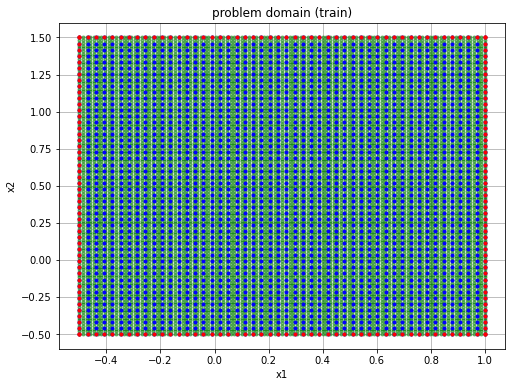

In [18]:
data = np.load('data/data.npz',allow_pickle=True)
x_pde = data['x_pde']
x_bd = data['x_bd']
x_test = data['x_test']

target_pde = data['target_pde'].item()
target_bd = data['target_bd'].item()
target_test = data['target_test'].item()


plot_domain_2d(x_pde=x_pde, x_bd=x_bd, x_test=x_test)


In [19]:



x_pde = torch.from_numpy(x_pde).float()
x_bd = torch.from_numpy(x_bd).float()
x_test = torch.from_numpy(x_test).float()
print(x_pde.shape)
print(x_bd.shape)
print(x_test.shape)


for eq in eq_names:
    target_pde[eq] = torch.from_numpy(target_pde[eq]).float()
    print(eq, target_pde[eq].shape)
for var in out_var:
    target_bd[var] = torch.from_numpy(target_bd[var]).float()
    target_test[var] = torch.from_numpy(target_test[var]).float()
    print(var, target_bd[var].shape, target_test[var].shape)


torch.Size([2500, 2])
torch.Size([200, 2])
torch.Size([12321, 2])
div torch.Size([2500, 1])
pde_u torch.Size([2500, 1])
pde_v torch.Size([2500, 1])
u torch.Size([200, 1]) torch.Size([12321, 1])
v torch.Size([200, 1]) torch.Size([12321, 1])
p torch.Size([200, 1]) torch.Size([12321, 1])


In [20]:
use_cuda = True
if use_cuda:
    x_pde = x_pde.cuda()
    x_bd = x_bd.cuda()
    x_test = x_test.cuda()

    for eq in eq_names:
        target_pde[eq] = target_pde[eq].cuda()
    for var in out_var:
        target_bd[var] = target_bd[var].cuda()
        target_test[var] = target_test[var].cuda()


In [21]:
def train_Adam(model, optimizer_Adam, lr_scheduler):
    # pde loss
    optimizer_Adam.zero_grad()
    op_pde = pde(x_pde, model)
    loss_pde = 0
    for eq in eq_names:
        loss_pde = loss_pde + criterion(op_pde[eq], target_pde[eq])
    #

    # bd fitting
    u_bd = model(x_bd)
    loss_bd = 0
    for i,var in enumerate(out_var):
        loss_bd = loss_bd + criterion(u_bd[:,[i]], target_bd[var])
    #


    loss = loss_pde + loss_bd

    loss.backward()

    optimizer_Adam.step()
    lr_scheduler.step()
    return loss.item(), loss_pde.item(), loss_bd.item()


def train_LBFGS(model, optimizer_LBFGS):

    def closure():
        if torch.is_grad_enabled():
            optimizer_LBFGS.zero_grad()
        #
        op_pde = pde(x_pde, model)
        loss_pde = 0
        for eq in eq_names:
            loss_pde = loss_pde + criterion(op_pde[eq], target_pde[eq])
        #

        # bd fitting
        u_bd = model(x_bd)
        loss_bd = 0
        for i,var in enumerate(out_var):
            loss_bd = loss_bd + criterion(u_bd[:,[i]], target_bd[var])
        #

        loss = loss_pde + loss_bd
        if loss.requires_grad:
            loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure()

    return loss.item()



In [ ]:
criterion = nn.MSELoss()
epochs_Adam = 5000
epochs_LBFGS = 201
lr = 0.001
gamma = 0.7
step_size = 2000


# model  = FCNet(input_dim=2, output_dim=1, width=500, hidden=1)
# optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)
#
# optimizer_LBFGS = optim.LBFGS(model.parameters(),
#                                    max_iter=20,
#                                    tolerance_grad=1.e-8,
#                                    tolerance_change=1.e-12)

In [31]:
# test
def model_test(x_in):
    out = my_prob.u_exact(x_in)
    u = out['u']
    v = out['v']
    p = out['p']
    return torch.cat([u,v,p], dim=1)
op_pde = pde(x_pde, model_test)
loss_pde = 0
for eq in eq_names:
    loss_pde = loss_pde + criterion(op_pde[eq], target_pde[eq])
#
# bd fitting
u_bd = model_test(x_bd)
loss_bd = 0
for i,var in enumerate(out_var):
    loss_bd = loss_bd + criterion(u_bd[:,[i]], target_bd[var])
#
loss = loss_pde + loss_bd
print(loss.item(), loss_pde.item(), loss_bd.item())

6.119996003028927e-14 3.4607648642442576e-14 2.6592307999714904e-14


In [23]:

def train(width):
    model  = FCNet(input_dim=2, output_dim=3, width=width, hidden=1)
    optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)

    optimizer_LBFGS = optim.LBFGS(model.parameters(),
                                       max_iter=20,
                                       tolerance_grad=1.e-8,
                                       tolerance_change=1.e-12)
    if use_cuda:
        model.cuda()


    record_epoch = []
    train_loss = []
    test_mse = []
    for epoch in range(epochs_Adam):
        loss, loss1, loss2 = train_Adam(model,optimizer_Adam,lr_scheduler)
        if epoch % 100 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            # get test mse
            mse_test_temp = 0
            u_out = model(x_test)
            for i,var in enumerate(out_var):
                mse_test_temp += criterion(target_test[var] ,u_out[:,[i]]).item()
            test_mse.append(mse_test_temp/3)

    print(loss)
    for epoch in range(epochs_Adam, epochs_Adam + epochs_LBFGS):
        loss = train_LBFGS(model,optimizer_LBFGS)
        if epoch % 20 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)

            # get test mse
            mse_test_temp = 0
            u_out = model(x_test)
            for i,var in enumerate(out_var):
                mse_test_temp += criterion(target_test[var] ,u_out[:,[i]]).item()
            test_mse.append(mse_test_temp/3)

    print(f'width={width} loss={loss}')
    return record_epoch, train_loss, test_mse

In [24]:
width_vec = [100,250,500,750,1000]
result_all = []
for width in width_vec:
    print(width,'.....................')
    record_epoch, train_loss, test_mse = train(width)
    result_all.append([record_epoch, train_loss, test_mse])

100 .....................
0 2.23610520362854
100 0.7360002994537354
200 0.7032356858253479
300 0.678667426109314
400 0.6496172547340393
500 0.6138643622398376
600 0.5753905773162842
700 0.5418221354484558
800 0.5192528963088989
900 0.5072625279426575
1000 0.5009186863899231
1100 0.49678274989128113
1200 0.49347370862960815
1300 0.49054986238479614
1400 0.48783451318740845
1500 0.4852233827114105
1600 0.4826425313949585
1700 0.48002856969833374
1800 0.4773080050945282
1900 0.4743625819683075
2000 0.47096142172813416
2100 0.4680502116680145
2200 0.464368999004364
2300 0.45939141511917114
2400 0.4521653950214386
2500 0.4415387809276581
2600 0.42736202478408813
2700 0.4109240472316742
2800 0.39373254776000977
2900 0.37692785263061523
3000 0.3608798384666443
3100 0.3460715711116791
3200 0.3322247862815857
3300 0.3186578154563904
3400 0.30460789799690247
3500 0.28979671001434326
3600 0.27437034249305725
3700 0.2588237226009369
3800 0.24347209930419922
3900 0.2285093516111374
4000 0.213958963

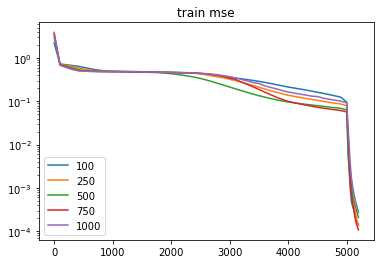

In [25]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][1], label=width_vec[i])
plt.yscale('log')
plt.title('train mse')
plt.legend()
plt.show()

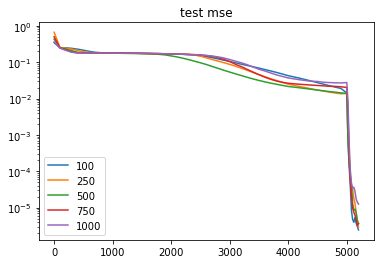

In [27]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][2], label=width_vec[i])
plt.yscale('log')
plt.title('test mse')
plt.legend()
plt.show()

In [33]:
result_all = np.array(result_all)
np.save('pinn_raw',result_all)

In [34]:
final_mse = []
final_mse_adam = []
for i in range(len(width_vec)):
    index = result_all[i][0]
    temp = np.array(result_all[i][2])
    final_mse.append(temp.min())
    final_mse_adam.append(temp[index==epochs_Adam].item())

df = pd.DataFrame({'basis_num': width_vec, 'mse_final': final_mse, 'mse_adam': final_mse_adam})
df.to_csv(f'pinn.csv',header=True, index=False, encoding='utf-8')